# OLX Job Recommendations using LightFM, SLIM, ALS and baseline models

## Process flow

![](https://github.com/RecoHut-Stanzas/S883757/raw/main/images/process_flow.svg)

## Setup

In [ ]:
!pip install -q implicit
!pip install -q lightfm

In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d olxdatascience/olx-jobs-interactions
!unzip /content/olx-jobs-interactions.zip

In [ ]:
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import random

import os
from pathlib import Path

from collections import defaultdict

import numpy as np
from tqdm import tqdm
from scipy import sparse
import scipy.sparse as sparse
from sklearn.preprocessing import normalize
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import ElasticNet
from sklearn.utils._testing import ignore_warnings

import implicit
from lightfm import LightFM

import tracemalloc
from datetime import datetime
from time import time

from functools import partial
import multiprocessing
from multiprocessing.pool import ThreadPool

## Data Loading and Sampling

In [ ]:
df = pd.read_csv('interactions.csv')
df.head()

,user,item,event,timestamp
0,27901,56865,click,1581465600
1,124480,115662,click,1581465600
2,159509,5150,click,1581465600
3,188861,109981,click,1581465600
4,207348,88746,click,1581465600


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65502201 entries, 0 to 65502200
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   user       int64 
 1   item       int64 
 2   event      object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 2.0+ GB


In [ ]:
df.user.astype('str').nunique()

3295942

In [ ]:
def get_interactions_subset(
    interactions, fraction_users, fraction_items, random_seed=10
):
    """
    Select subset from interactions based on fraction of users and items
    :param interactions: Original interactions
    :param fraction_users: Fraction of users
    :param fraction_items: Fraction of items
    :param random_seed: Random seed
    :return: Dataframe with subset of interactions
    """

    def _get_subset_by_column(column, fraction):
        column_df = interactions[column].unique()
        subset = set(np.random.choice(column_df, int(len(column_df) * fraction)))
        return interactions[interactions[column].isin(subset)]

    np.random.seed(random_seed)
    if fraction_users < 1:
        interactions = _get_subset_by_column("user", fraction_users)

    if fraction_items < 1:
        interactions = _get_subset_by_column("item", fraction_items)

    return interactions

In [ ]:
df_subset_users = get_interactions_subset(
    df, fraction_users=0.1, fraction_items=1, random_seed=10
)

In [ ]:
df_subset_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6210394 entries, 2 to 65502187
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   user       int64 
 1   item       int64 
 2   event      object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 236.9+ MB


In [ ]:
df_subset_users.to_parquet('df_subset_users.parquet.snappy', compression='snappy')

In [ ]:
df_subset_items = get_interactions_subset(
    df, fraction_users=1, fraction_items=0.1, random_seed=10
)

In [ ]:
df_subset_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6159193 entries, 10 to 65502199
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   user       int64 
 1   item       int64 
 2   event      object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 235.0+ MB


In [ ]:
df_subset_items.to_parquet('df_subset_items.parquet.snappy', compression='snappy')

## Utils

### Data split

In [ ]:
def splitting_functions_factory(function_name):
    """Returns splitting function based on name"""
    if function_name == "by_time":
        return split_by_time


def split_by_time(interactions, fraction_test, random_state=30):
    """
    Splits interactions by time. Returns tuple of dataframes: train and test.
    """

    np.random.seed(random_state)

    test_min_timestamp = np.percentile(
        interactions["timestamp"], 100 * (1 - fraction_test)
    )

    train = interactions[interactions["timestamp"] < test_min_timestamp]
    test = interactions[interactions["timestamp"] >= test_min_timestamp]

    return train, test


def filtering_restrict_to_train_users(train, test):
    """
    Returns test DataFrame restricted to users from train set.
    """
    train_users = set(train["user"])
    return test[test["user"].isin(train_users)]


def filtering_already_interacted_items(train, test):
    """
    Filters out (user, item) pairs from the test set if the given user interacted with a given item in train set.
    """
    columns = test.columns
    already_interacted_items = train[["user", "item"]].drop_duplicates()
    merged = pd.merge(
        test, already_interacted_items, on=["user", "item"], how="left", indicator=True
    )
    test = merged[merged["_merge"] == "left_only"]
    return test[columns]


def filtering_restrict_to_unique_user_item_pair(dataframe):
    """
    Returns pd.DataFrame where each (user, item) pair appears only once.
    A list of corresponding events is stores instead of a single event.
    Returned timestamp is the timestamp of the first (user, item) interaction.
    """
    return (
        dataframe.groupby(["user", "item"])
        .agg({"event": list, "timestamp": "min"})
        .reset_index()
    )


def split(
    interactions,
    splitting_config=None,
    restrict_to_train_users=True,
    filter_out_already_interacted_items=True,
    restrict_train_to_unique_user_item_pairs=True,
    restrict_test_to_unique_user_item_pairs=True,
    replace_events_by_ones=True,
):
    """
    Main function used for splitting the dataset into the train and test sets.
    Parameters
    ----------
    interactions: pd.DataFrame
        Interactions dataframe
    splitting_config : dict, optional
        Dict with name and parameters passed to splitting function.
        Currently only name="by_time" supported.
    restrict_to_train_users : boolean, optional
        Whether to restrict users in the test set only to users from the train set.
    filter_out_already_interacted_items : boolean, optional
        Whether to filter out (user, item) pairs from the test set if the given user interacted with a given item
        in the train set.
    restrict_test_to_unique_user_item_pairs
        Whether to return only one row per (user, item) pair in test set.
    """

    if splitting_config is None:
        splitting_config = {
            "name": "by_time",
            "fraction_test": 0.2,
        }

    splitting_name = splitting_config["name"]
    splitting_config = {k: v for k, v in splitting_config.items() if k != "name"}

    train, test = splitting_functions_factory(splitting_name)(
        interactions=interactions, **splitting_config
    )

    if restrict_to_train_users:
        test = filtering_restrict_to_train_users(train, test)

    if filter_out_already_interacted_items:
        test = filtering_already_interacted_items(train, test)

    if restrict_train_to_unique_user_item_pairs:
        train = filtering_restrict_to_unique_user_item_pair(train)

    if restrict_test_to_unique_user_item_pairs:
        test = filtering_restrict_to_unique_user_item_pair(test)

    if replace_events_by_ones:
        train["event"] = 1
        test["event"] = 1

    return train, test

### Metrics

In [ ]:
def ranking_metrics(test_matrix, recommendations, k=10):
    """
    Calculates ranking metrics (precision, recall, F1, F0.5, NDCG, mAP, MRR, LAUC, HR)
    based on test interactions matrix and recommendations
    :param test_matrix: Test interactions matrix
    :param recommendations: Recommendations
    :param k: Number of top recommendations to calculate metrics on
    :return: Dataframe with metrics
    """

    items_number = test_matrix.shape[1]
    metrics = {
        "precision": 0,
        "recall": 0,
        "F_1": 0,
        "F_05": 0,
        "ndcg": 0,
        "mAP": 0,
        "MRR": 0,
        "LAUC": 0,
        "HR": 0,
    }

    denominators = {
        "relevant_users": 0,
    }

    for (user_count, user) in tqdm(enumerate(recommendations[:, 0])):
        u_interacted_items = get_interacted_items(test_matrix, user)
        interacted_items_amount = len(u_interacted_items)

        if interacted_items_amount > 0:  # skip users with no items in test set
            denominators["relevant_users"] += 1

            # evaluation
            success_statistics = calculate_successes(
                k, recommendations, u_interacted_items, user_count
            )

            user_metrics = calculate_ranking_metrics(
                success_statistics,
                interacted_items_amount,
                items_number,
                k,
            )

            for metric_name in metrics:
                metrics[metric_name] += user_metrics[metric_name]

    metrics = {
        name: metric / denominators["relevant_users"]
        for name, metric in metrics.items()
    }

    return pd.DataFrame.from_dict(metrics, orient="index").T


def calculate_ranking_metrics(
    success_statistics,
    interacted_items_amount,
    items_number,
    k,
):
    """
    Calculates ranking metrics based on success statistics
    :param success_statistics: Success statistics dictionary
    :param interacted_items_amount:
    :param items_number:
    :param k: Number of top recommendations to calculate metrics on
    :return: Dictionary with metrics
    """
    precision = success_statistics["total_amount"] / k
    recall = success_statistics["total_amount"] / interacted_items_amount
    user_metrics = dict(
        precision=precision,
        recall=recall,
        F_1=calculate_f(precision, recall, 1),
        F_05=calculate_f(precision, recall, 0.5),
        ndcg=calculate_ndcg(interacted_items_amount, k, success_statistics["total"]),
        mAP=calculate_map(success_statistics, interacted_items_amount, k),
        MRR=calculate_mrr(success_statistics["total"]),
        LAUC=calculate_lauc(
            success_statistics, interacted_items_amount, items_number, k
        ),
        HR=success_statistics["total_amount"] > 0,
    )
    return user_metrics


def calculate_mrr(user_successes):
    return (
        1 / (user_successes.nonzero()[0][0] + 1)
        if user_successes.nonzero()[0].size > 0
        else 0
    )


def calculate_f(precision, recall, f):
    return (
        (f ** 2 + 1) * (precision * recall) / (f ** 2 * precision + recall)
        if precision + recall > 0
        else 0
    )


def calculate_lauc(successes, interacted_items_amount, items_number, k):
    return (
        np.dot(successes["cumsum"], 1 - successes["total"])
        + (successes["total_amount"] + interacted_items_amount)
        / 2
        * ((items_number - interacted_items_amount) - (k - successes["total_amount"]))
    ) / ((items_number - interacted_items_amount) * interacted_items_amount)


def calculate_map(successes, interacted_items_amount, k):
    return np.dot(successes["cumsum"] / np.arange(1, k + 1), successes["total"]) / min(
        k, interacted_items_amount
    )


def calculate_ndcg(interacted_items_amount, k, user_successes):
    cumulative_gain = 1.0 / np.log2(np.arange(2, k + 2))
    cg_sum = np.cumsum(cumulative_gain)
    return (
        np.dot(user_successes, cumulative_gain)
        / cg_sum[min(k, interacted_items_amount) - 1]
    )


def calculate_successes(k, recommendations, u_interacted_items, user_count):

    items = recommendations[user_count, 1 : k + 1]
    user_successes = np.isin(items, u_interacted_items)

    return dict(
        total=user_successes.astype(int),
        total_amount=user_successes.sum(),
        cumsum=np.cumsum(user_successes),
    )


def get_reactions(test_matrix, user):
    return test_matrix.data[test_matrix.indptr[user] : test_matrix.indptr[user + 1]]


def get_interacted_items(test_matrix, user):
    return test_matrix.indices[test_matrix.indptr[user] : test_matrix.indptr[user + 1]]


def diversity_metrics(
    test_matrix, formatted_recommendations, original_recommendations, k=10
):
    """
    Calculates diversity metrics
    (% if recommendations in test, test coverage, Shannon, Gini, users without recommendations)
    based on test interactions matrix and recommendations
    :param test_matrix: user/item interactions' matrix
    :param formatted_recommendations: recommendations where user and item ids were replaced by respective codes based on test_matrix
    :param original_recommendations: original format recommendations
    :param k: Number of top recommendations to calculate metrics on
    :return: Dataframe with metrics
    """

    formatted_recommendations = formatted_recommendations[:, : k + 1]

    frequency_statistics = calculate_frequencies(formatted_recommendations, test_matrix)

    with np.errstate(
        divide="ignore"
    ):  # let's put zeros we items with 0 frequency and ignore division warning
        log_frequencies = np.nan_to_num(
            np.log(frequency_statistics["frequencies"]), posinf=0, neginf=0
        )

    metrics = dict(
        reco_in_test=frequency_statistics["recommendations_in_test_n"]
        / frequency_statistics["total_recommendations_n"],
        test_coverage=frequency_statistics["recommended_items_n"]
        / test_matrix.shape[1],
        Shannon=-np.dot(frequency_statistics["frequencies"], log_frequencies),
        Gini=calculate_gini(
            frequency_statistics["frequencies"], frequency_statistics["items_in_test_n"]
        ),
        users_without_reco=original_recommendations.iloc[:, 1].isna().sum()
        / len(original_recommendations),
        users_without_k_reco=original_recommendations.iloc[:, k - 1].isna().sum()
        / len(original_recommendations),
    )

    return pd.DataFrame.from_dict(metrics, orient="index").T


def calculate_gini(frequencies, items_in_test_n):
    return (
        np.dot(
            frequencies,
            np.arange(
                1 - items_in_test_n,
                items_in_test_n,
                2,
            ),
        )
        / (items_in_test_n - 1)
    )


def calculate_frequencies(formatted_recommendations, test_matrix):
    frequencies = defaultdict(
        int, [(item, 0) for item in list(set(test_matrix.indices))]
    )
    for item in formatted_recommendations[:, 1:].flat:
        frequencies[item] += 1
    recommendations_out_test_n = frequencies[-1]
    del frequencies[-1]
    frequencies = np.array(list(frequencies.values()))
    items_in_test_n = len(frequencies)
    recommended_items_n = len(frequencies[frequencies > 0])
    recommendations_in_test_n = np.sum(frequencies)
    frequencies = frequencies / np.sum(frequencies)
    frequencies = np.sort(frequencies)
    return dict(
        frequencies=frequencies,
        items_in_test_n=items_in_test_n,
        recommended_items_n=recommended_items_n,
        recommendations_in_test_n=recommendations_in_test_n,
        total_recommendations_n=recommendations_out_test_n + recommendations_in_test_n,
    )

### Evaluator

In [ ]:
def preprocess_test(test: pd.DataFrame):
    """
    Preprocesses test set to speed up evaluation
    """

    def _map_column(test, column):
        test[f"{column}_code"] = test[column].astype("category").cat.codes
        return dict(zip(test[column], test[f"{column}_code"]))

    test = test.copy()

    test.columns = ["user", "item", "event", "timestamp"]
    user_map = _map_column(test, "user")
    item_map = _map_column(test, "item")

    test_matrix = sparse.csr_matrix(
        (np.ones(len(test)), (test["user_code"], test["item_code"]))
    )
    return user_map, item_map, test_matrix


class Evaluator:
    """
    Class used for models evaluation
    """

    # pylint: disable=too-many-instance-attributes
    # pylint: disable=too-many-arguments
    def __init__(
        self,
        recommendations_path: Path,
        test_path: Path,
        k,
        models_to_evaluate,
    ):
        self.recommendations_path = recommendations_path
        self.test_path = test_path
        self.k = k
        self.models_to_evaluate = models_to_evaluate
        self.located_models = None
        self.test = None
        self.user_map = None
        self.item_map = None
        self.test_matrix = None

        self.evaluation_results = []

    def prepare(self):
        """
        Prepares test set and models to evaluate
        """

        def _get_models(models_to_evaluate, recommendations_path):
            models = [
                (file_name.split(".")[0], file_name)
                for file_name in os.listdir(recommendations_path)
            ]
            if models_to_evaluate:
                return [model for model in models if model[0] in models_to_evaluate]
            return models

        self.test = pd.read_csv(self.test_path, compression="gzip").astype(
            {"user": str, "item": str}
        )
        self.user_map, self.item_map, self.test_matrix = preprocess_test(self.test)

        self.located_models = _get_models(
            self.models_to_evaluate, self.recommendations_path
        )

    def evaluate_models(self):
        """
        Evaluating multiple models
        """

        def _read_recommendations(file_name):
            return pd.read_csv(
                os.path.join(self.recommendations_path, file_name),
                header=None,
                compression="gzip",
                dtype=str,
            )

        for model, file_name in self.located_models:
            recommendations = _read_recommendations(file_name)
            evaluation_result = self.evaluate(
                original_recommendations=recommendations,
            )

            evaluation_result.insert(0, "model_name", model)
            self.evaluation_results.append(evaluation_result)
        self.evaluation_results = pd.concat(self.evaluation_results).set_index(
            "model_name"
        )
        if "precision" in self.evaluation_results.columns:
            self.evaluation_results = self.evaluation_results.sort_values(
                by="precision", ascending=False
            )

    def evaluate(
        self,
        original_recommendations: pd.DataFrame,
    ):
        """
        Evaluate single model
        """

        def _format_recommendations(recommendations, user_id_code, item_id_code):
            users = recommendations.iloc[:, :1].applymap(
                lambda x: user_id_code.setdefault(str(x), -1)
            )
            items = recommendations.iloc[:, 1:].applymap(
                lambda x: -1 if pd.isna(x) else item_id_code.setdefault(x, -1)
            )
            return np.array(pd.concat([users, items], axis=1))

        original_recommendations = original_recommendations.iloc[:, : self.k + 1].copy()

        formatted_recommendations = _format_recommendations(
            original_recommendations, self.user_map, self.item_map
        )

        evaluation_results = pd.concat(
            [
                ranking_metrics(
                    self.test_matrix,
                    formatted_recommendations,
                    k=self.k,
                ),
                diversity_metrics(
                    self.test_matrix,
                    formatted_recommendations,
                    original_recommendations,
                    self.k,
                ),
            ],
            axis=1,
        )

        return evaluation_results

### Helpers

In [ ]:
def overlap(df1, df2):
    """
    Returns the Overlap Coefficient with respect to (user, item) pairs.
    We assume uniqueness of (user, item) pairs in DataFrames
    (not recommending the same item to the same users multiple times)).
    :param df1: DataFrame which index is user_id and column ["items"] is a list of recommended items
    :param df2: DataFrame which index is user_id and column ["items"] is a list of recommended items
    """
    nb_items = min(df1["items"].apply(len).sum(), df2["items"].apply(len).sum())

    merged_df = pd.merge(df1, df2, left_index=True, right_index=True)
    nb_common_items = merged_df.apply(
        lambda x: len(set(x["items_x"]) & set(x["items_y"])), axis=1
    ).sum()

    return 1.00 * nb_common_items / nb_items


def get_recommendations(models_to_evaluate, recommendations_path):
    """
    Returns dictionary with model_names as keys and recommendations as values.
    :param models_to_evaluate: List of model names
    :param recommendations_path: Stored recommendations directory
    """
    models = [
        (file_name.split(".")[0], file_name)
        for file_name in os.listdir(recommendations_path)
    ]

    return {
        model[0]: pd.read_csv(
            os.path.join(recommendations_path, model[1]),
            header=None,
            compression="gzip",
            dtype=str,
        )
        for model in models
        if model[0] in models_to_evaluate
    }

In [ ]:
def dict_to_df(dictionary):
    """
    Creates pandas dataframe from dictionary
    :param dictionary: Original dictionary
    :return: Dataframe from original dictionary
    """
    return pd.DataFrame({k: [v] for k, v in dictionary.items()})


def efficiency(path, base_params=None):
    """
    Parametrized decorator for executing function with efficiency logging and
    storing the results under the given path
    """
    base_params = base_params or {}

    def efficiency_decorator(func):
        def wrapper(*args, **kwargs):
            tracemalloc.start()
            start_time = time()
            result = func(*args, **kwargs)
            execution_time = time() - start_time
            _, peak = tracemalloc.get_traced_memory()
            dict_to_df(
                {
                    **base_params,
                    **{
                        "function_name": func.__name__,
                        "execution_time": execution_time,
                        "memory_peak": peak,
                    },
                }
            ).to_csv(path, index=False)
            tracemalloc.stop()
            return result

        return wrapper

    return efficiency_decorator


def get_unix_path(path):
    """
    Returns the input path with unique csv filename
    """
    return path / f"{datetime.utcnow().strftime('%Y_%m_%d_%H_%M_%S_%f')}.csv"


def df_from_dir(dir_path):
    """
    Returns pd.DataFrame with concatenated files from the given path
    """
    files_read = [
        pd.read_csv(dir_path / filename)
        for filename in os.listdir(dir_path)
        if filename.endswith(".csv")
    ]
    return pd.concat(files_read, axis=0, ignore_index=True)


def get_interactions_subset(
    interactions, fraction_users, fraction_items, random_seed=10
):
    """
    Select subset from interactions based on fraction of users and items
    :param interactions: Original interactions
    :param fraction_users: Fraction of users
    :param fraction_items: Fraction of items
    :param random_seed: Random seed
    :return: Dataframe with subset of interactions
    """

    def _get_subset_by_column(column, fraction):
        column_df = interactions[column].unique()
        subset = set(np.random.choice(column_df, int(len(column_df) * fraction)))
        return interactions[interactions[column].isin(subset)]

    np.random.seed(random_seed)
    if fraction_users < 1:
        interactions = _get_subset_by_column("user", fraction_users)

    if fraction_items < 1:
        interactions = _get_subset_by_column("item", fraction_items)

    return interactions

## Data loading

In [ ]:
def load_interactions(data_path):
    return pd.read_csv(data_path,
            compression='gzip',
            header=0,names=["user", "item", "event", "timestamp"],
            ).astype({"user": str, "item": str, "event": str, "timestamp": int})

def load_target_users(path):
    return list(pd.read_csv(path, compression="gzip", header=None).astype(str).iloc[:, 0])

def save_recommendations(recommendations, path):
    recommendations.to_csv(path, index=False, header=False, compression="gzip")

In [ ]:
data_path = 'df_subset_items.parquet.snappy'

interactions = pd.read_parquet(data_path)
interactions.columns = ["user", "item", "event", "timestamp"]
interactions = interactions.astype({"user": str, "item": str, "event": str, "timestamp": int})
interactions.head()

,user,item,event,timestamp
10,748807,167669,click,1581465600
19,1398480,8064,click,1581465600
21,1541984,7050,click,1581465600
24,1686074,50001,click,1581465600
50,96276,78456,click,1581465601


In [ ]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6159193 entries, 10 to 65502199
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   user       object
 1   item       object
 2   event      object
 3   timestamp  int64 
dtypes: int64(1), object(3)
memory usage: 235.0+ MB


## EDA

In [ ]:
n_users = interactions["user"].nunique()
n_items = interactions["item"].nunique()
n_interactions = len(interactions)

interactions_per_user = interactions.groupby("user").size()
interactions_per_item = interactions.groupby("item").size()

print(f"We have {n_users} users, {n_items} items and {n_interactions} interactions.\n")

print(
    f"Data sparsity (% of missing entries) is {round(100 * (1- n_interactions / (n_users * n_items)), 4)}%.\n"
)

print(
    f"Average number of interactions per user is {round(interactions_per_user.mean(), 3)}\
    (standard deviation {round(interactions_per_user.std(ddof=0),3)}).\n"
)

print(
    f"Average number of interactions per item is {round(interactions_per_item.mean(), 3)}\
    (standard deviation {round(interactions_per_item.std(ddof=0),3)}).\n"
)

We have 1535397 users, 17668 items and 6159193 interactions.

Data sparsity (% of missing entries) is 99.9773%.

Average number of interactions per user is 4.011    (standard deviation 6.539).

Average number of interactions per item is 348.607    (standard deviation 608.238).



In [ ]:
def compute_quantiles(series, quantiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]):
    return pd.DataFrame(
        [[quantile, series.quantile(quantile)] for quantile in quantiles],
        columns=["quantile", "value"],
    )


print("Interactions distribution per user:")
compute_quantiles(interactions_per_user)

Interactions distribution per user:


,quantile,value
0,0.01,1.0
1,0.10,1.0
2,0.25,1.0
3,0.50,2.0
4,0.75,4.0
5,0.90,9.0
6,0.99,32.0


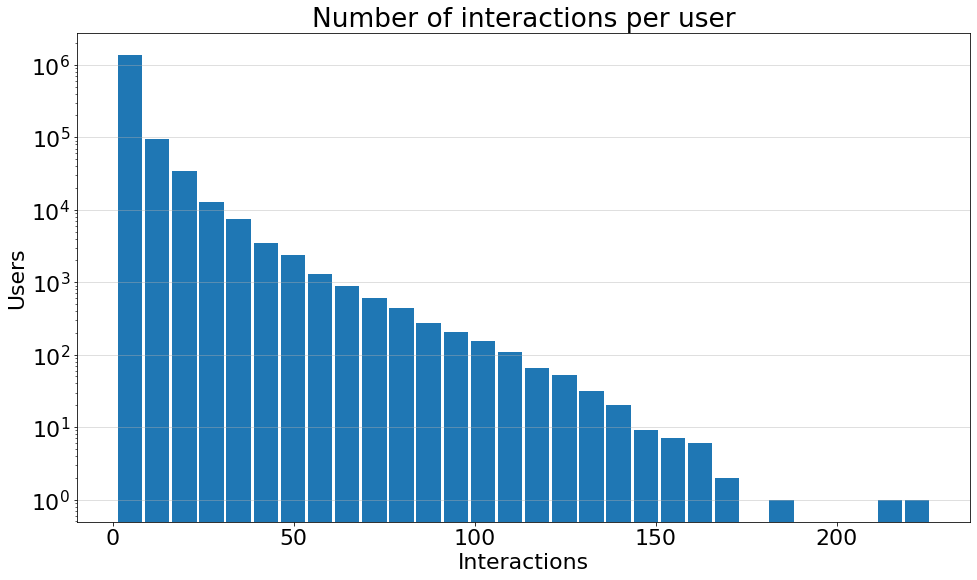

In [ ]:
def plot_interactions_distribution(series, aggregation="user", ylabel="Users", bins=30):
    matplotlib.rcParams.update({"font.size": 22})
    series.plot.hist(bins=bins, rwidth=0.9, logy=True, figsize=(16, 9))
    plt.title(f"Number of interactions per {aggregation}")
    plt.xlabel("Interactions")
    plt.ylabel(ylabel)
    plt.grid(axis="y", alpha=0.5)


plot_interactions_distribution(interactions_per_user, "user", "Users")

In [ ]:
print("Interactions distribution per item:")
compute_quantiles(interactions_per_item)

Interactions distribution per item:


,quantile,value
0,0.01,1.00
1,0.10,1.00
2,0.25,3.00
3,0.50,134.00
4,0.75,423.25
5,0.90,958.00
6,0.99,2858.99


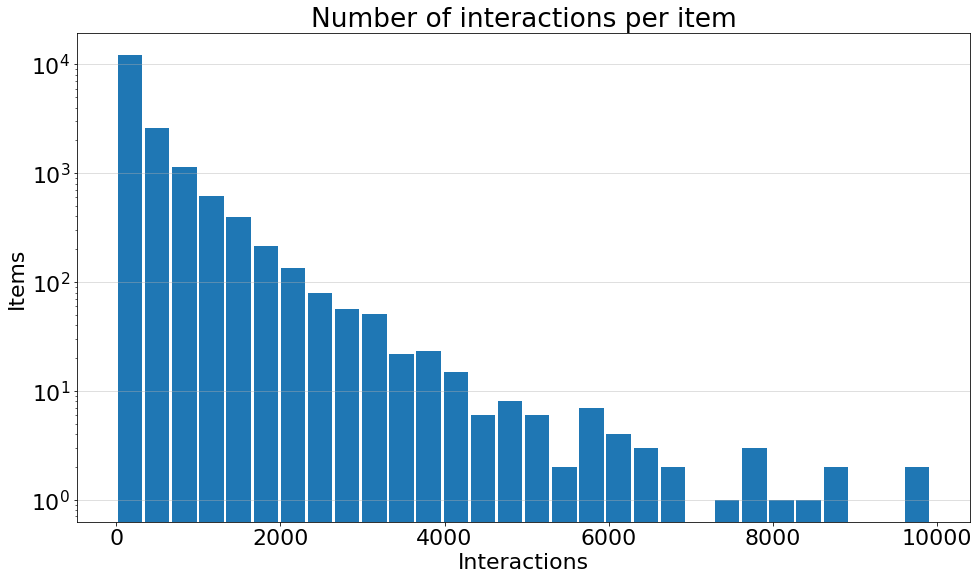

In [ ]:
plot_interactions_distribution(interactions_per_item, "item", "Items")

In [ ]:
event_frequency = pd.DataFrame(
    interactions["event"].value_counts() / len(interactions)
).rename(columns={"event": "frequency"})

event_frequency["frequency"] = event_frequency["frequency"].apply(
    lambda x: f"{round(100*x,3)}%"
)
event_frequency

,frequency
click,89.895%
contact_phone_click_1,2.582%
bookmark,2.487%
chat_click,2.138%
contact_chat,1.451%
contact_partner_click,0.682%
contact_phone_click_2,0.666%
contact_phone_click_3,0.1%


In [ ]:
def unix_to_day(timestamps):
    min_timestamp = timestamps.min()
    seconds_in_day = 60*60*24
    return (timestamps - min_timestamp)//seconds_in_day + 1


interactions["day"] = unix_to_day(interactions["timestamp"])

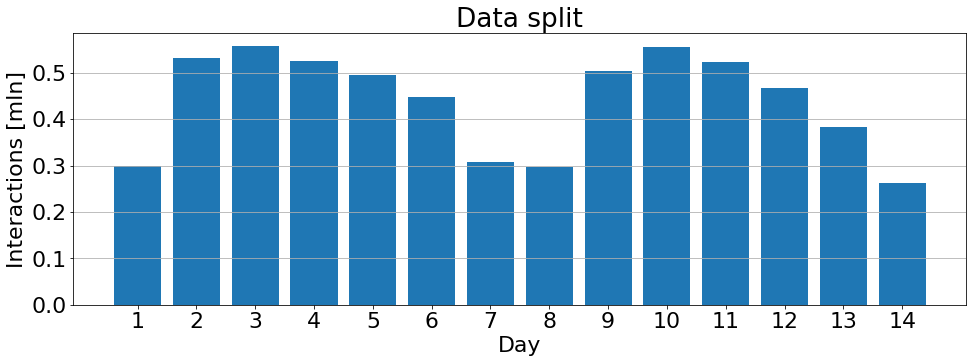

In [ ]:
def plot_interactions_over_time(series):
    freq = series.value_counts()
    labels, counts = freq.index, freq.values/10**6
    
    matplotlib.rcParams.update({"font.size": 22})
    plt.figure(figsize=(16,5))
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    plt.title(f"Data split")
    plt.xlabel("Day")
    plt.ylabel("Interactions [mln]")
    plt.grid(axis="y")
    
plot_interactions_over_time(interactions["day"])

## Preprocessing

### Splitting

In [ ]:
random_seed=10
validation_target_users_size = 10000
validation_fraction_users = 0.2
validation_fraction_items = 0.2

In [ ]:
# split into train_and_validation and test
train_and_validation, test = split(interactions)
train_and_validation.to_csv('train_valid.gzip', compression="gzip", index=None)
test.to_csv('test.gzip', compression="gzip", index=None)

# split into train and validation
interactions_subset = get_interactions_subset(
    interactions=train_and_validation,
    fraction_users=validation_fraction_users,
    fraction_items=validation_fraction_items,
)
train, validation = split(interactions_subset)
train.to_csv('train.gzip', compression="gzip", index=None)
validation.to_csv('validation.gzip', compression="gzip", index=None)

# prepare target_users
test["user"].drop_duplicates().to_csv('target_users_all.gzip',
                                      header=None,
                                      index=None,
                                      compression="gzip"
)

# prepare target_users for validation
np.random.seed(random_seed)
validation_users = validation["user"].drop_duplicates()
validation_users.sample(
    n=min(validation_target_users_size, len(validation_users))
).to_csv('target_users_subset_validation.gzip',
         header=None,
         index=None,
         compression="gzip",
         )

### Encoding

In [ ]:
def dataprep(interactions):
    """
    Prepare interactions dataset for training model
    """

    data = interactions.copy()

    user_code_id = dict(enumerate(data["user"].unique()))
    user_id_code = {v: k for k, v in user_code_id.items()}
    data["user_code"] = data["user"].apply(user_id_code.get)

    item_code_id = dict(enumerate(data["item"].unique()))
    item_id_code = {v: k for k, v in item_code_id.items()}
    data["item_code"] = data["item"].apply(item_id_code.get)

    train_ui = sparse.csr_matrix(
        (np.ones(len(data)), (data["user_code"], data["item_code"]))
    )

    return train_ui, {'user_code_id':user_code_id,
                      'user_id_code':user_id_code,
                      'item_code_id':item_code_id,
                      'item_id_code':item_id_code}

## Models

### Base Class

In [ ]:
class BaseRecommender:
    """Base recommender interface"""

    def preprocess(self):
        """Implement any needed input data preprocessing"""
        raise NotImplementedError

    def fit(self):
        """Implement model fitter"""
        raise NotImplementedError

    def recommend(self, *args, **kwargs):
        """Implement recommend method
        Should return a DataFrame containing
        * user_id: id of the user for whom we provide recommendations
        * n columns containing item recommendations (or None if missing)
        """
        raise NotImplementedError

### TopPop

In [ ]:
class TopPop(BaseRecommender):
    """
    TopPop recommender, which recommends the most popular items
    """

    def __init__(self, train_ui, encode_maps, show_progress=True):
        super().__init__()

        self.popular_items = None

        self.train_ui = train_ui
        self.user_id_code = encode_maps['user_id_code']
        self.user_code_id = encode_maps['user_code_id']
        self.item_code_id = encode_maps['item_code_id']

        self.show_progress = show_progress

    def fit(self):
        """
        Fit the model
        """
        self.popular_items = (-self.train_ui.sum(axis=0).A.ravel()).argsort()

    def recommend(
        self,
        target_users,
        n_recommendations,
        filter_out_interacted_items=True,
    ) -> pd.DataFrame:
        """
            Recommends n_recommendations items for target_users
        :return:
            pd.DataFrame (user, item_1, item_2, ..., item_n)
        """

        with ThreadPool() as thread_pool:
            recommendations = list(
                tqdm(
                    thread_pool.imap(
                        partial(
                            self.recommend_per_user,
                            n_recommendations=n_recommendations,
                            filter_out_interacted_items=filter_out_interacted_items,
                        ),
                        target_users,
                    ),
                    disable=not self.show_progress,
                )
            )

        return pd.DataFrame(recommendations)

    def recommend_per_user(
        self, user, n_recommendations, filter_out_interacted_items=True
    ):
        """
        Recommends n items per user
        :param user: User id
        :param n_recommendations: Number of recommendations
        :param filter_out_interacted_items: boolean value to filter interacted items
        :return: list of format [user_id, item1, item2 ...]
        """
        u_code = self.user_id_code.get(user)
        u_recommended_items = []

        if u_code is not None:
            exclude_items = []
            if filter_out_interacted_items:
                exclude_items = self.train_ui.indices[
                    self.train_ui.indptr[u_code] : self.train_ui.indptr[u_code + 1]
                ]

            u_recommended_items = self.popular_items[
                : n_recommendations + len(exclude_items)
            ]

            u_recommended_items = [
                self.item_code_id[i]
                for i in u_recommended_items
                if i not in exclude_items
            ]

            u_recommended_items = u_recommended_items[:n_recommendations]

        return (
            [user]
            + u_recommended_items
            + [None] * (n_recommendations - len(u_recommended_items))
        )

### Random

In [ ]:
class Random(BaseRecommender):
    """
    TopPop recommender, which recommends the most popular items
    """

    def __init__(self, train_ui, encode_maps, show_progress=True):
        super().__init__()

        self.train_ui = train_ui
        self.user_id_code = encode_maps['user_id_code']
        self.user_code_id = encode_maps['user_code_id']
        self.item_code_id = encode_maps['item_code_id']

        self.show_progress = show_progress

    def fit(self):
        """
        Fit the model
        """
        pass

    def recommend(
        self,
        target_users,
        n_recommendations,
        filter_out_interacted_items=True,
    ) -> pd.DataFrame:
        """
            Recommends n_recommendations items for target_users
        :return:
            pd.DataFrame (user, item_1, item_2, ..., item_n)
        """

        with ThreadPool() as thread_pool:
            recommendations = list(
                tqdm(
                    thread_pool.imap(
                        partial(
                            self.recommend_per_user,
                            n_recommendations=n_recommendations,
                            filter_out_interacted_items=filter_out_interacted_items,
                        ),
                        target_users,
                    ),
                    disable=not self.show_progress,
                )
            )

        return pd.DataFrame(recommendations)

    def recommend_per_user(
        self, user, n_recommendations, filter_out_interacted_items=True
    ):
        """
        Recommends n items per user
        :param user: User id
        :param n_recommendations: Number of recommendations
        :param filter_out_interacted_items: boolean value to filter interacted items
        :return: list of format [user_id, item1, item2 ...]
        """
        u_code = self.user_id_code.get(user)
        u_recommended_items = []

        if u_code is not None:
            exclude_items = []
            if filter_out_interacted_items:
                exclude_items = self.train_ui.indices[
                    self.train_ui.indptr[u_code] : self.train_ui.indptr[u_code + 1]
                ]

            u_recommended_items = random.sample(
                range(self.train_ui.shape[1]), n_recommendations + len(exclude_items)
            )

            u_recommended_items = [
                self.item_code_id[i]
                for i in u_recommended_items
                if i not in exclude_items
            ]

            u_recommended_items = u_recommended_items[:n_recommendations]

        return (
            [user]
            + u_recommended_items
            + [None] * (n_recommendations - len(u_recommended_items))
        )

### ALS

In [ ]:
class ALS(BaseRecommender):
    """
    Module implementing a wrapper for the ALS model
    Wrapper over ALS model
    """

    def __init__(self, train_ui,
                 encode_maps,
                 factors=100,
                 regularization=0.01,
                 use_gpu=False,
                 iterations=15,
                 event_weights_multiplier=100,
                 show_progress=True,
                 ):
        """
        Source of descriptions:
        https://github.com/benfred/implicit/blob/master/implicit/als.py
        Alternating Least Squares
        A Recommendation Model based on the algorithms described in the paper
        'Collaborative Filtering for Implicit Feedback Datasets'
        with performance optimizations described in 'Applications of the
        Conjugate Gradient Method for Implicit Feedback Collaborative Filtering.'
        Parameters
        ----------
        factors : int, optional
            The number of latent factors to compute
        regularization : float, optional
            The regularization factor to use
        use_gpu : bool, optional
            Fit on the GPU if available, default is to run on CPU
        iterations : int, optional
            The number of ALS iterations to use when fitting data
        event_weights_multiplier: int, optional
            The multiplier of weights.
            Used to find a tradeoff between the importance of interacted and not interacted items.
        """

        super().__init__()

        self.train_ui = train_ui
        self.user_id_code = encode_maps['user_id_code']
        self.user_code_id = encode_maps['user_code_id']
        self.item_code_id = encode_maps['item_code_id']
        self.mapping_user_test_items = None
        self.similarity_matrix = None

        self.show_progress = show_progress

        self.model = implicit.als.AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            use_gpu=use_gpu,
            iterations=iterations,
        )

        self.event_weights_multiplier = event_weights_multiplier

    def fit(self):
        """
        Fit the model
        """
        self.model.fit(self.train_ui.T, show_progress=self.show_progress)

    def recommend(
        self,
        target_users,
        n_recommendations,
        filter_out_interacted_items=True,
    ) -> pd.DataFrame:
        """
            Recommends n_recommendations items for target_users
        :return:
            pd.DataFrame (user, item_1, item_2, ..., item_n)
        """

        with ThreadPool() as thread_pool:
            recommendations = list(
                tqdm(
                    thread_pool.imap(
                        partial(
                            self.recommend_per_user,
                            n_recommendations=n_recommendations,
                            filter_out_interacted_items=filter_out_interacted_items,
                        ),
                        target_users,
                    ),
                    disable=not self.show_progress,
                )
            )

        return pd.DataFrame(recommendations)

    def recommend_per_user(
        self, user, n_recommendations, filter_out_interacted_items=True
    ):
        """
        Recommends n items per user
        :param user: User id
        :param n_recommendations: Number of recommendations
        :param filter_out_interacted_items: boolean value to filter interacted items
        :return: list of format [user_id, item1, item2 ...]
        """
        u_code = self.user_id_code.get(user)
        u_recommended_items = []
        if u_code is not None:

            u_recommended_items = list(
                zip(
                    *self.model.recommend(
                        u_code,
                        self.train_ui,
                        N=n_recommendations,
                        filter_already_liked_items=filter_out_interacted_items,
                    )
                )
            )[0]

            u_recommended_items = [self.item_code_id[i] for i in u_recommended_items]

        return (
            [user]
            + u_recommended_items
            + [None] * (n_recommendations - len(u_recommended_items))
        )

### LightFM

In [ ]:
class LFM(BaseRecommender):
    """
    Module implementing a wrapper for the ALS model
    Wrapper over LightFM model
    """

    def __init__(self, train_ui,
                 encode_maps,
                no_components=30,
                k=5,
                n=10,
                learning_schedule="adagrad",
                loss="logistic",
                learning_rate=0.05,
                rho=0.95,
                epsilon=1e-06,
                item_alpha=0.0,
                user_alpha=0.0,
                max_sampled=10,
                random_state=42,
                epochs=20,
                show_progress=True,
                 ):
        """
        Source of descriptions:
        https://making.lyst.com/lightfm/docs/_modules/lightfm/lightfm.html#LightFM
        A hybrid latent representation recommender model.
        The model learns embeddings (latent representations in a high-dimensional
        space) for users and items in a way that encodes user preferences over items.
        When multiplied together, these representations produce scores for every item
        for a given user; items scored highly are more likely to be interesting to
        the user.
        The user and item representations are expressed in terms of representations
        of their features: an embedding is estimated for every feature, and these
        features are then summed together to arrive at representations for users and
        items. For example, if the movie 'Wizard of Oz' is described by the following
        features: 'musical fantasy', 'Judy Garland', and 'Wizard of Oz', then its
        embedding will be given by taking the features' embeddings and adding them
        together. The same applies to user features.
        The embeddings are learned through `stochastic gradient
        descent <http://cs231n.github.io/optimization-1/>`_ methods.
        Four loss functions are available:
        - logistic: useful when both positive (1) and negative (-1) interactions
        are present.
        - BPR: Bayesian Personalised Ranking [1]_ pairwise loss. Maximises the
        prediction difference between a positive example and a randomly
        chosen negative example. Useful when only positive interactions
        are present and optimising ROC AUC is desired.
        - WARP: Weighted Approximate-Rank Pairwise [2]_ loss. Maximises
        the rank of positive examples by repeatedly sampling negative
        examples until rank violating one is found. Useful when only
        positive interactions are present and optimising the top of
        the recommendation list (precision@k) is desired.
        - k-OS WARP: k-th order statistic loss [3]_. A modification of WARP that
        uses the k-th positive example for any given user as a basis for pairwise
        updates.
        Two learning rate schedules are available:
        - adagrad: [4]_
        - adadelta: [5]_
        Parameters
        ----------
        no_components: int, optional
            the dimensionality of the feature latent embeddings.
        k: int, optional
            for k-OS training, the k-th positive example will be selected from the
            n positive examples sampled for every user.
        n: int, optional
            for k-OS training, maximum number of positives sampled for each update.
        learning_schedule: string, optional
            one of ('adagrad', 'adadelta').
        loss: string, optional
            one of  ('logistic', 'bpr', 'warp', 'warp-kos'): the loss function.
        learning_rate: float, optional
            initial learning rate for the adagrad learning schedule.
        rho: float, optional
            moving average coefficient for the adadelta learning schedule.
        epsilon: float, optional
            conditioning parameter for the adadelta learning schedule.
        item_alpha: float, optional
            L2 penalty on item features. Tip: setting this number too high can slow
            down training. One good way to check is if the final weights in the
            embeddings turned out to be mostly zero. The same idea applies to
            the user_alpha parameter.
        user_alpha: float, optional
            L2 penalty on user features.
        max_sampled: int, optional
            maximum number of negative samples used during WARP fitting.
            It requires a lot of sampling to find negative triplets for users that
            are already well represented by the model; this can lead to very long
            training times and overfitting. Setting this to a higher number will
            generally lead to longer training times, but may in some cases improve
            accuracy.
        random_state: int seed, RandomState instance, or None
            The seed of the pseudo random number generator to use when shuffling
            the data and initializing the parameters.
        epochs: (int, optional) number of epochs to run
        """

        super().__init__()

        self.model = LightFM(
            no_components=no_components,
            k=k,
            n=n,
            learning_schedule=learning_schedule,
            loss=loss,
            learning_rate=learning_rate,
            rho=rho,
            epsilon=epsilon,
            item_alpha=item_alpha,
            user_alpha=user_alpha,
            max_sampled=max_sampled,
            random_state=random_state,
        )
        self.epochs = epochs

        self.train_ui = train_ui
        self.user_id_code = encode_maps['user_id_code']
        self.user_code_id = encode_maps['user_code_id']
        self.item_code_id = encode_maps['item_code_id']
        self.mapping_user_test_items = None
        self.similarity_matrix = None

        self.show_progress = show_progress

    def fit(self):
        """
        Fit the model
        """
        self.model.fit(
            self.train_ui,
            epochs=self.epochs,
            num_threads=multiprocessing.cpu_count(),
            verbose=self.show_progress,
        )

    def recommend(
        self,
        target_users,
        n_recommendations,
        filter_out_interacted_items=True,
    ) -> pd.DataFrame:
        """
            Recommends n_recommendations items for target_users
        :return:
            pd.DataFrame (user, item_1, item_2, ..., item_n)
        """

        self.items_to_recommend = np.arange(len(self.item_code_id))

        with ThreadPool() as thread_pool:
            recommendations = list(
                tqdm(
                    thread_pool.imap(
                        partial(
                            self.recommend_per_user,
                            n_recommendations=n_recommendations,
                            filter_out_interacted_items=filter_out_interacted_items,
                        ),
                        target_users,
                    ),
                    disable=not self.show_progress,
                )
            )

        return pd.DataFrame(recommendations)

    def recommend_per_user(
        self, user, n_recommendations, filter_out_interacted_items=True
    ):
        """
        Recommends n items per user
        :param user: User id
        :param n_recommendations: Number of recommendations
        :param filter_out_interacted_items: boolean value to filter interacted items
        :return: list of format [user_id, item1, item2 ...]
        """
        u_code = self.user_id_code.get(user)

        if u_code is not None:
            interacted_items = self.train_ui.indices[
                self.train_ui.indptr[u_code] : self.train_ui.indptr[u_code + 1]
            ]

            scores = self.model.predict(int(u_code), self.items_to_recommend)

            item_recommendations = self.items_to_recommend[np.argsort(-scores)][
                : n_recommendations + len(interacted_items)
            ]
            item_recommendations = [
                self.item_code_id[item]
                for item in item_recommendations
                if item not in interacted_items
            ]

        return (
            [user]
            + item_recommendations
            + [None] * (n_recommendations - len(item_recommendations))
        )

### RP3Beta

In [ ]:
class RP3Beta(BaseRecommender):
    """
    Module implementing a RP3Beta model
    RP3Beta model proposed in the paper "Updatable, Accurate, Diverse, and Scalable Recommendations for Interactive
    Applications". In our implementation we perform direct computations on sparse matrices instead of random walks
    approximation.
    """

    def __init__(self, train_ui,
                 encode_maps,
                 alpha=1,
                 beta=0,
                 show_progress=True):
        
        super().__init__()

        self.train_ui = train_ui
        self.user_id_code = encode_maps['user_id_code']
        self.user_code_id = encode_maps['user_code_id']
        self.item_code_id = encode_maps['item_code_id']

        self.alpha = alpha
        self.beta = beta
        self.p_ui = None
        self.similarity_matrix = None

        self.show_progress = show_progress

    def fit(self):
        """
        Fit the model
        """
        # Define Pui
        self.p_ui = normalize(self.train_ui, norm="l1", axis=1).power(self.alpha)

        # Define Piu
        p_iu = normalize(
            self.train_ui.transpose(copy=True).tocsr(), norm="l1", axis=1
        ).power(self.alpha)

        self.similarity_matrix = p_iu * self.p_ui
        item_orders = (self.train_ui > 0).sum(axis=0).A.ravel()

        self.similarity_matrix *= sparse.diags(1 / item_orders.clip(min=1) ** self.beta)

    def recommend(
        self,
        target_users,
        n_recommendations,
        filter_out_interacted_items=True,
    ) -> pd.DataFrame:
        """
            Recommends n_recommendations items for target_users
        :return:
            pd.DataFrame (user, item_1, item_2, ..., item_n)
        """

        with ThreadPool() as thread_pool:
            recommendations = list(
                tqdm(
                    thread_pool.imap(
                        partial(
                            self.recommend_per_user,
                            n_recommendations=n_recommendations,
                            filter_out_interacted_items=filter_out_interacted_items,
                        ),
                        target_users,
                    ),
                    disable=not self.show_progress,
                )
            )

        return pd.DataFrame(recommendations)

    def recommend_per_user(
        self, user, n_recommendations, filter_out_interacted_items=True
    ):
        """
        Recommends n items per user
        :param user: User id
        :param n_recommendations: Number of recommendations
        :param filter_out_interacted_items: boolean value to filter interacted items
        :return: list of format [user_id, item1, item2 ...]
        """
        u_code = self.user_id_code.get(user)
        u_recommended_items = []
        if u_code is not None:

            exclude_items = []
            if filter_out_interacted_items:
                exclude_items = self.train_ui.indices[
                    self.train_ui.indptr[u_code] : self.train_ui.indptr[u_code + 1]
                ]

            scores = self.p_ui[u_code] * self.similarity_matrix
            u_recommended_items = scores.indices[
                (-scores.data).argsort()[: n_recommendations + len(exclude_items)]
            ]

            u_recommended_items = [
                self.item_code_id[i]
                for i in u_recommended_items
                if i not in exclude_items
            ]

            u_recommended_items = u_recommended_items[:n_recommendations]

        return (
            [user]
            + u_recommended_items
            + [None] * (n_recommendations - len(u_recommended_items))
        )

### SLIM

In [ ]:
class SLIM(BaseRecommender):
    """
    Module implementing SLIM model
    SLIM model proposed in "SLIM: Sparse Linear Methods for Top-N Recommender Systems
    """

    def __init__(self, train_ui,
                 encode_maps,
                 alpha=0.0001,
                 l1_ratio=0.5,
                 iterations=3,
                 show_progress=True):
        
        super().__init__()

        self.train_ui = train_ui
        self.user_id_code = encode_maps['user_id_code']
        self.user_code_id = encode_maps['user_code_id']
        self.item_code_id = encode_maps['item_code_id']

        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.iterations = iterations
        self.similarity_matrix = None

        self.show_progress = show_progress

    def fit_per_item(self, column_id):
        """
        Fits ElasticNet per item
        :param column_id: Id of column to setup as predicted value
        :return: coefficients of the ElasticNet model
        """
        model = ElasticNet(
            alpha=self.alpha,
            l1_ratio=self.l1_ratio,
            positive=True,
            fit_intercept=False,
            copy_X=False,
            precompute=True,
            selection="random",
            max_iter=self.iterations,
        )
        # set to zeros all entries in the given column of train_ui
        y = self.train_ui[:, column_id].A
        start_indptr = self.train_ui.indptr[column_id]
        end_indptr = self.train_ui.indptr[column_id + 1]
        column_ratings = self.train_ui.data[start_indptr:end_indptr].copy()
        self.train_ui.data[start_indptr:end_indptr] = 0

        # learn item-item similarities
        model.fit(self.train_ui, y)

        # return original ratings to train_ui
        self.train_ui.data[start_indptr:end_indptr] = column_ratings

        return model.sparse_coef_.T

    @ignore_warnings(category=ConvergenceWarning)
    def fit(self):
        """
        Fit the model
        """
        self.train_ui = self.train_ui.tocsc()

        with ThreadPool() as thread_pool:
            coefs = list(
                tqdm(
                    thread_pool.imap(self.fit_per_item, range(self.train_ui.shape[1])),
                    disable=not self.show_progress,
                )
            )

        self.similarity_matrix = sparse.hstack(coefs).tocsr()

        self.train_ui = self.train_ui.tocsr()

    def recommend(
        self,
        target_users,
        n_recommendations,
        filter_out_interacted_items=True,
    ):
        """
            Recommends n_recommendations items for target_users
        :return:
            pd.DataFrame (user, item_1, item_2, ..., item_n)
        """

        with ThreadPool() as thread_pool:
            recommendations = list(
                tqdm(
                    thread_pool.imap(
                        partial(
                            self.recommend_per_user,
                            n_recommendations=n_recommendations,
                            filter_out_interacted_items=filter_out_interacted_items,
                        ),
                        target_users,
                    ),
                    disable=not self.show_progress,
                )
            )

        return pd.DataFrame(recommendations)

    def recommend_per_user(
        self, user, n_recommendations, filter_out_interacted_items=True
    ):
        """
        Recommends n items per user
        :param user: User id
        :param n_recommendations: Number of recommendations
        :param filter_out_interacted_items: boolean value to filter interacted items
        :return: list of format [user_id, item1, item2 ...]
        """
        u_code = self.user_id_code.get(user)
        if u_code is not None:

            exclude_items = []
            if filter_out_interacted_items:
                exclude_items = self.train_ui.indices[
                    self.train_ui.indptr[u_code] : self.train_ui.indptr[u_code + 1]
                ]

            scores = self.train_ui[u_code] * self.similarity_matrix
            u_recommended_items = scores.indices[
                (-scores.data).argsort()[: n_recommendations + len(exclude_items)]
            ]

            u_recommended_items = [
                self.item_code_id[i]
                for i in u_recommended_items
                if i not in exclude_items
            ][:n_recommendations]
        return (
            [user]
            + u_recommended_items
            + [None] * (n_recommendations - len(u_recommended_items))
        )

## Runs

In [ ]:
# load the training data
interactions_train = load_interactions('train.gzip')

# encode user ids and convert interactions into sparse interaction matrix
train_ui, encode_maps = dataprep(interactions_train)

In [ ]:
# # load target users
target_users = load_target_users('target_users_subset_validation.gzip')

In [ ]:
# models list
models = {'itempop': TopPop,
          'random': Random,
          'als': ALS,
          'lightfm': LFM,
          'rp3': RP3Beta,
          'slim': SLIM,
          }

### Training Random Model

In [ ]:
model_name = 'random'

Model = models[model_name]

# number of recommendations
N_RECOMMENDATIONS = 10

# initiate the model
model = Model(train_ui, encode_maps)

# train the model
model.fit()

# # recommend
recommendations = model.recommend(target_users=target_users, n_recommendations=N_RECOMMENDATIONS)

# # save the recommendations
save_recommendations(recommendations, '{}.gzip'.format(model_name))

5373it [00:00, 17610.42it/s]


### Training Item Pop Model

In [ ]:
model_name = 'itempop'

Model = models[model_name]

# number of recommendations
N_RECOMMENDATIONS = 10

# initiate the model
model = Model(train_ui, encode_maps)

# train the model
model.fit()

# # recommend
recommendations = model.recommend(target_users=target_users, n_recommendations=N_RECOMMENDATIONS)

# # save the recommendations
save_recommendations(recommendations, '{}.gzip'.format(model_name))

5373it [00:00, 15331.51it/s]


### Training ALS Model

In [ ]:
model_name = 'als'

Model = models[model_name]

FACTORS = 400
REGULARIZATION = 0.1
ITERATIONS = 6
EVENT_WEIGHTS_MULTIPLIER = 100

N_RECOMMENDATIONS = 10

# initiate the model
model = Model(train_ui,
              encode_maps,
              factors=FACTORS,
              regularization=REGULARIZATION,
              iterations=ITERATIONS,
              event_weights_multiplier=EVENT_WEIGHTS_MULTIPLIER,
              )

# train the model
model.fit()

# # recommend
recommendations = model.recommend(target_users=target_users, n_recommendations=N_RECOMMENDATIONS)

# # save the recommendations
save_recommendations(recommendations, '{}.gzip'.format(model_name))

  0%|          | 0/6 [00:00<?, ?it/s]

5373it [00:04, 1170.63it/s]


### Training LightFM Model

In [ ]:
model_name = 'lightfm'

Model = models[model_name]

no_components=200
learning_schedule="adadelta"
loss="warp"
max_sampled=61
epochs=11

N_RECOMMENDATIONS = 10

# initiate the model
model = Model(train_ui,
              encode_maps,
              no_components=no_components,
              learning_schedule=learning_schedule,
              loss=loss,
              max_sampled=max_sampled,
              epochs=epochs,
              )

# train the model
model.fit()

# # recommend
recommendations = model.recommend(target_users=target_users, n_recommendations=N_RECOMMENDATIONS)

# # save the recommendations
save_recommendations(recommendations, '{}.gzip'.format(model_name))

Epoch: 100%|██████████| 11/11 [00:24<00:00,  2.22s/it]
5373it [00:11, 486.61it/s]


### Training RP3Beta Model

In [ ]:
model_name = 'rp3'

Model = models[model_name]

ALPHA = 1
BETA = 0

N_RECOMMENDATIONS = 10

# initiate the model
model = Model(train_ui,
              encode_maps,
              alpha=ALPHA,
              beta=BETA,
              )

# train the model
model.fit()

# # recommend
recommendations = model.recommend(target_users=target_users, n_recommendations=N_RECOMMENDATIONS)

# # save the recommendations
save_recommendations(recommendations, '{}.gzip'.format(model_name))

5373it [00:03, 1637.26it/s]


### Training SLIM Model

In [ ]:
model_name = 'slim'

Model = models[model_name]

N_RECOMMENDATIONS = 10

# initiate the model
model = Model(train_ui,
              encode_maps,
              )

# train the model
model.fit()

# # recommend
recommendations = model.recommend(target_users=target_users, n_recommendations=N_RECOMMENDATIONS)

# # save the recommendations
save_recommendations(recommendations, '{}.gzip'.format(model_name))

2376it [00:14, 163.75it/s]
5373it [00:02, 2016.80it/s]


### Evaluation

In [ ]:
evaluator = Evaluator(
    recommendations_path='/content',
    test_path='validation.gzip',
    k=10,
    models_to_evaluate=list(models.keys()),
)

evaluator.prepare()

evaluator.evaluate_models()

evaluator.evaluation_results

5373it [00:00, 11755.66it/s]
5373it [00:00, 11352.94it/s]
5373it [00:00, 11671.65it/s]
5373it [00:00, 11761.84it/s]
5373it [00:00, 11632.48it/s]
5373it [00:00, 11745.21it/s]


,precision,recall,F_1,F_05,ndcg,mAP,MRR,LAUC,HR,reco_in_test,test_coverage,Shannon,Gini,users_without_reco,users_without_k_reco
model_name,,,,,,,,,,,,,,,
rp3,0.023004,0.187388,0.040282,0.027746,0.124805,0.100025,0.114362,0.590383,0.214964,0.874577,0.896476,6.444258,0.640194,0.002978,0.030151
lightfm,0.018053,0.148499,0.031659,0.021784,0.102187,0.083530,0.095443,0.570879,0.169738,0.897394,0.786344,6.558708,0.603250,0.000000,0.000000
slim,0.015336,0.125498,0.026881,0.018503,0.094253,0.080069,0.091860,0.559400,0.145729,0.467430,0.467695,5.874312,0.798783,0.170854,0.697190
als,0.011148,0.091039,0.019523,0.013446,0.061763,0.049716,0.057786,0.542032,0.107203,0.841280,0.740088,6.327765,0.690216,0.000000,0.000000
itempop,0.004262,0.033163,0.007400,0.005128,0.017145,0.011278,0.014088,0.512925,0.041876,1.000000,0.010279,2.339907,0.993313,0.000000,0.000000
random,0.000577,0.004510,0.000994,0.000692,0.001861,0.000966,0.001209,0.498580,0.005770,0.565364,0.986050,7.180956,0.128753,0.000000,0.000000


In [ ]:
evaluator = Evaluator(
    recommendations_path='/content',
    test_path='validation.gzip',
    k=10,
    models_to_evaluate=list(models.keys()),
)

evaluator.prepare()

evaluator.evaluate_models()

evaluator.evaluation_results

5373it [00:00, 12328.94it/s]
5373it [00:00, 11966.13it/s]
5373it [00:00, 11717.03it/s]
5373it [00:00, 11618.24it/s]
5373it [00:00, 11584.71it/s]
5373it [00:00, 11754.46it/s]


,precision,recall,F_1,F_05,ndcg,mAP,MRR,LAUC,HR,reco_in_test,test_coverage,Shannon,Gini,users_without_reco,users_without_k_reco
model_name,,,,,,,,,,,,,,,
rp3,0.023004,0.187388,0.040282,0.027746,0.124805,0.100025,0.114362,0.590383,0.214964,0.874577,0.896476,6.444258,0.640194,0.002978,0.030151
lightfm,0.018053,0.148499,0.031659,0.021784,0.102187,0.083530,0.095443,0.570879,0.169738,0.897394,0.786344,6.558708,0.603250,0.000000,0.000000
slim,0.015336,0.125498,0.026881,0.018503,0.094253,0.080069,0.091860,0.559400,0.145729,0.467430,0.467695,5.874312,0.798783,0.170854,0.697190
als,0.011148,0.091039,0.019523,0.013446,0.061763,0.049716,0.057786,0.542032,0.107203,0.841280,0.740088,6.327765,0.690216,0.000000,0.000000
itempop,0.004262,0.033163,0.007400,0.005128,0.017145,0.011278,0.014088,0.512925,0.041876,1.000000,0.010279,2.339907,0.993313,0.000000,0.000000
random,0.000577,0.004510,0.000994,0.000692,0.001861,0.000966,0.001209,0.498580,0.005770,0.565364,0.986050,7.180956,0.128753,0.000000,0.000000


---

In [ ]:
!apt-get -qq install tree
!rm -r sample_data

In [ ]:
!tree --du -h -C .

.
├── [122K]  als.gzip
├── [ 69M]  df_subset_items.parquet.snappy
├── [ 69M]  df_subset_users.parquet.snappy
├── [2.0G]  interactions.csv
├── [ 26K]  itempop.gzip
├── [137K]  lightfm.gzip
├── [509M]  olx-jobs-interactions.zip
├── [151K]  random.gzip
├── [4.5K]  README.txt
├── [121K]  rp3.gzip
├── [ 61K]  slim.gzip
├── [524K]  target_users_all.gzip
├── [ 20K]  target_users_subset_validation.gzip
├── [4.0M]  test.gzip
├── [837K]  train.gzip
├── [ 30M]  train_valid.gzip
└── [ 61K]  validation.gzip

 2.6G used in 0 directories, 17 files


In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d -p lightfm

Author: Sparsh A.

Last updated: 2021-12-10 10:37:34

lightfm: 1.16

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

scipy     : 1.4.1
implicit  : 0.4.8
numpy     : 1.19.5
IPython   : 5.5.0
sklearn   : 0.0
matplotlib: 3.2.2
sys       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
pandas    : 1.1.5



In [ ]:
import sklearn
sklearn.__version__

'1.0.1'

---

**END**